# Downsampling boxcar
An example of how to implement the downsampling boxcar
e.g.
![Boxcar flow diagram](boxcar_flowdiag.png)


In [183]:
from pylab import *
import matplotlib as mpl
import numpy as np
%matplotlib inline


1.0

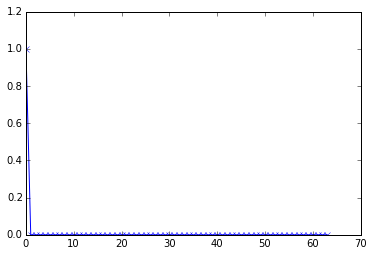

In [269]:
def mkbox(N, w, off=0):
    '''
    Make a boxcar with N samples, w of which are 1 starting at off
    '''
    assert w >= 0
    assert off >=0
    assert w + off < N
    x = np.zeros(N)
    x[off:off+w] = 1
    return x

x = mkbox(64, 1, 0)
plot(x, 'x-')
ylim(0, 1.2)
x.sum()


In [302]:
def push(v, arr):
    '''Push v on the given array at position 0
    :return: The value of the FIFO that fell off the end'''
    final = arr[-1]
    arr[1:] = arr[0:-1]
    arr[0] = v
    
    return final


class DownsamplingBoxcar(object):
    def __init__(self):
        self._fifo1 = np.zeros(4) # fifo for every sample
        self._fifo2 = np.zeros(2) # fifo for every 2nd sample
        self._fifo3 = np.zeros(2) # fifo for every 4th sample
        self.nstates = 6
        self._states = np.zeros(self.nstates)
        self.nds = 2 # number of downsamplers
        self._ds_averages = np.zeros(self.nds) # downsampler average values
        self.t = 0
        
    def boxcar_sample(self, x):
        '''Boxcar a single sample and return all boxcar values'''
        
        self._states[0]  = x
        self._states[1] += x - self._fifo1[1]
        self._states[2] += x - self._fifo1[2]
        self._states[3] += x - self._fifo1[3]
        
        # update average of first down sampler - based on value of last thing in the fifo.
        self._ds_averages[0] += self._fifo1[-1]
        
        # now push
        push(x, self._fifo1)

        if self.t % 2 == 0: # downsample every second sample
            self._states[4] += self._states[1] - self._fifo2[-1]
            self._ds_averages[1] += self._fifo2[-1]
            push(self._ds_averages[0], self._fifo2)
            self._ds_averages[0] = 0 # clear average
            
            # update next average downstream
     
            
        if self.t % 4 == 0:
            self._states[5] += self._states[3] - self._fifo3[-1]
            push(self._ds_averages[1], self._fifo3)
            self._ds_averages[1] = 0
        
        self.t += 1


        return self._states.copy()
        
    def dobox(self, xarr):
        return np.array([self.boxcar_sample(x) for x in xarr])
    
    __call__ = dobox

(32, 6)
1.0
[ 1.  2.  3.  4.  8. 16.]


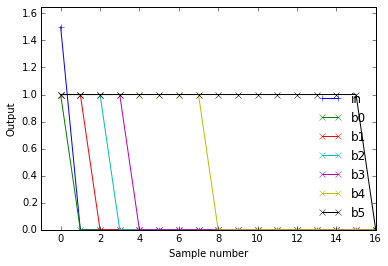

In [303]:
bc = DownsamplingBoxcar()
x = mkbox(32, 1, 0)
xbox = bc(x)
print(xbox.shape)
plot(x*1.5, '+-')
plot(xbox[:, [0,1,2,3,4,5]], 'x-')
ylim(0, max(xbox.max(), (x*1.5).max())*1.1)
print(x.sum())
print(xbox.sum(axis=0))
labels = ['in'] + ['b{}'.format(b) for b in range(xbox.shape[0])]
legend(labels, frameon=False, loc='lower right')
xlim(-1,16)
xlabel("Sample number")
ylabel('Output')

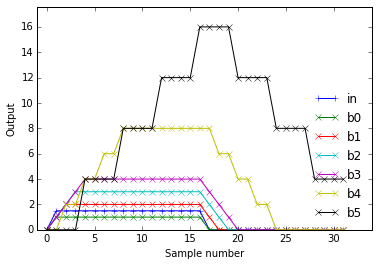

In [315]:
def pltbox(N, w, off, ax=None):

    if ax is None:
        ax = gca()
        
    bc = DownsamplingBoxcar()
    x = mkbox(N, w, off)
    xbox = bc(x)
    ax.plot(x*1.5, '+-')
    ax.plot(xbox[:, :], 'x-')
    ax.set_ylim(0, max(xbox.max(), (x*1.5).max())*1.1)
    labels = ['in'] + ['b{}'.format(b) for b in range(xbox.shape[0])]
    ax.legend(labels, frameon=False, loc='lower right')
    ax.set_xlim(-1, off + w + 16 + 1)
    ax.set_xlabel("Sample number")
    ax.set_ylabel('Output')
    
pltbox(32, 16, 1)

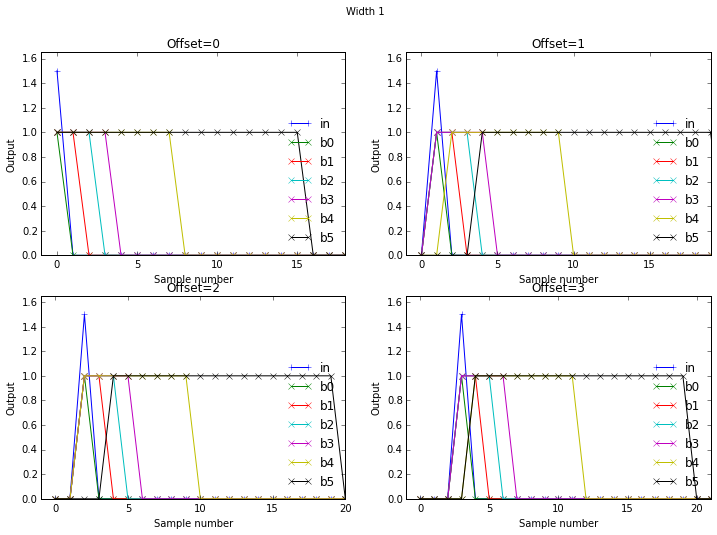

In [305]:
fig, ax = subplots(2,2)
fig.suptitle('Width 1')
fig.set_size_inches(12, 8)
ax = ax.flatten()
for offset, a in enumerate(ax):
    pltbox(36, 1, offset, a)
    a.set_title('Offset={}'.format(offset))

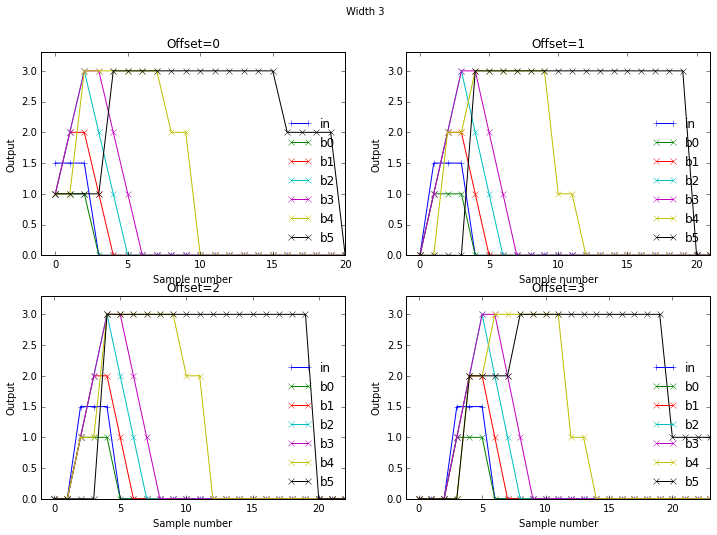

In [306]:
fig, ax = subplots(2,2)
fig.suptitle('Width 3')
fig.set_size_inches(12, 8)
ax = ax.flatten()
for offset, a in enumerate(ax):
    pltbox(36, 3, offset, a)
    a.set_title('Offset={}'.format(offset))

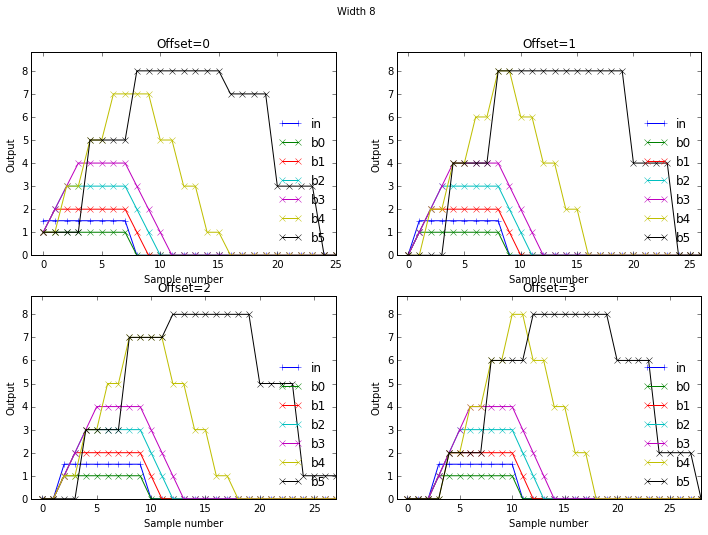

In [307]:
fig, ax = subplots(2,2)
fig.set_size_inches(12, 8)
fig.suptitle('Width 8')

ax = ax.flatten()
for offset, a in enumerate(ax):
    pltbox(36, 8, offset, a)
    a.set_title('Offset={}'.format(offset))

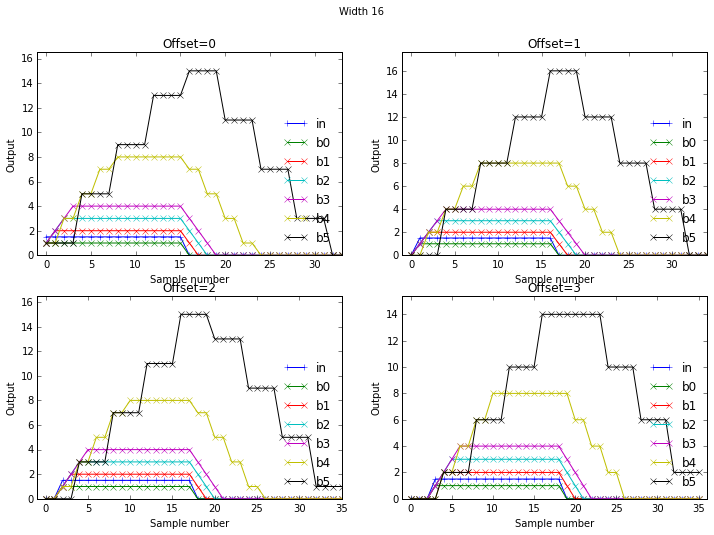

In [308]:
fig, ax = subplots(2,2)
fig.set_size_inches(12, 8)
fig.suptitle('Width 16')

ax = ax.flatten()
for offset, a in enumerate(ax):
    pltbox(36, 16, offset, a)
    a.set_title('Offset={}'.format(offset))